In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [ ]:
fake = Faker()
fake.seed(12345)
random.seed(12345)
 
# Define format of the data we would like to generate
FORMATS = ['short',
           'medium',
           'long',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'd MMM YYY',
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']
 

LOCALES = ['en_US']
 
def load_date():
    """
        Loads some fake dates
        :returns: tuple containing human readable string, machine readable string, and date object
    """
    dt = fake.date_object()
 
    try:
        human_readable = format_date(dt, format=random.choice(FORMATS),  locale='en_US')
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',','')
        machine_readable = dt.isoformat()
 
    except AttributeError as e:
        return None, None, None
 
    return human_readable, machine_readable, dt
 
def load_dataset(m):
    """
        Loads a dataset with m examples and vocabularies
        :m: the number of examples to generate
    """
 
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    Tx = 30
 
 
    for i in tqdm(range(m)):
        h, m, _ = load_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))
 
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'],
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v:k for k,v in inv_machine.items()}
 
    return dataset, human, machine, inv_machine
 
def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
 
    X, Y = zip(*dataset)
    print("X shape before preprocess: {}".format(X))
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]
    print("X shape from preprocess: {}".format(X.shape))
    print("Y shape from preprocess: {}".format(Y))
 
    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))
 
    return X, np.array(Y), Xoh, Yoh
 
def string_to_int(string, length, vocab):
    """
    Converts all strings in the vocabulary into a list of integers representing the positions of the
    input string's characters in the "vocab"
 
    Arguments:
    string -- input string, e.g. 'Wed 10 Jul 2007'
    length -- the number of time steps you'd like, determines if the output will be padded or cut
    vocab -- vocabulary, dictionary used to index every character of your "string"
 
    Returns:
    rep -- list of integers (or '<unk>') (size = length) representing the position of the string's character in the vocabulary
    """
 
    #make lower to standardize
    string = string.lower()
    string = string.replace(',','')
 
    if len(string) > length:
        string = string[:length]
 
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
 
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))
 
    return rep


In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 23983.69it/s]


In [43]:
dataset

[('9 may 1998', '1998-05-09'),
 ('10.09.70', '1970-09-10'),
 ('4/28/90', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('tuesday july 8 2008', '2008-07-08'),
 ('08 sep 1999', '1999-09-08'),
 ('1 jan 1981', '1981-01-01'),
 ('monday may 22 1995', '1995-05-22'),
 ('friday june 16 1978', '1978-06-16'),
 ('friday june 18 1999', '1999-06-18'),
 ('8 oct 1987', '1987-10-08'),
 ('tuesday april 1 2008', '2008-04-01'),
 ('6 september 2012', '2012-09-06'),
 ('12 november 1981', '1981-11-12'),
 ('friday august 19 2011', '2011-08-19'),
 ('25 08 07', '2007-08-25'),
 ('18 september 1982', '1982-09-18'),
 ('friday february 25 1994', '1994-02-25'),
 ('friday march 19 1976', '1976-03-19'),
 ('20.02.06', '2006-02-20'),
 ('17.01.98', '1998-01-17'),
 ('october 24 2009', '2009-10-24'),
 ('17 apr 2004', '2004-04-17'),
 ('03.05.81', '1981-05-03'),
 ('31 jan 1980', '1980-01-31'),
 ('01 jan 1984', '1984-01-01'),
 ('5 de

In [3]:
human_vocab

{' ': 0,
 '.': 1,
 '/': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'y': 34,
 '<unk>': 35,
 '<pad>': 36}

In [4]:
machine_vocab

{'-': 0,
 '0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}

In [46]:
inv_machine_vocab

{0: '-',
 1: '0',
 2: '1',
 3: '2',
 4: '3',
 5: '4',
 6: '5',
 7: '6',
 8: '7',
 9: '8',
 10: '9'}

In [42]:
dataset[:10]#[0][1])

[('9 may 1998', '1998-05-09'),
 ('10.09.70', '1970-09-10'),
 ('4/28/90', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('tuesday july 8 2008', '2008-07-08'),
 ('08 sep 1999', '1999-09-08'),
 ('1 jan 1981', '1981-01-01'),
 ('monday may 22 1995', '1995-05-22')]

In [44]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X shape before preprocess: ('9 may 1998', '10.09.70', '4/28/90', 'thursday january 26 1995', 'monday march 7 1983', 'sunday may 22 1988', 'tuesday july 8 2008', '08 sep 1999', '1 jan 1981', 'monday may 22 1995', 'friday june 16 1978', 'friday june 18 1999', '8 oct 1987', 'tuesday april 1 2008', '6 september 2012', '12 november 1981', 'friday august 19 2011', '25 08 07', '18 september 1982', 'friday february 25 1994', 'friday march 19 1976', '20.02.06', '17.01.98', 'october 24 2009', '17 apr 2004', '03.05.81', '31 jan 1980', '01 jan 1984', '5 dec 2018', 'saturday april 19 1975', 'sunday december 5 1982', 'tuesday march 30 1993', '01.12.91', 'august 8 1971', 'friday march 23 2001', 'sunday february 7 1993', 'saturday october 30 1971', '10/2/04', '1 january 2017', 'friday april 10 1998', '3/27/70', '15 jun 1970', 'march 7 2015', '23.02.81', '23 jun 2009', '3/4/82', '7/2/89', 'october 9 1976', 'wednesday may 28 2014', '18 mar 1998', 'wednesday march 16 1977', 'sunday may 15 2016', 'monday 

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [8]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index].shape)
print("Target after preprocessing (indices):", Y[index].shape)
print()
print("Source after preprocessing (one-hot):", Xoh[index].shape)
print("Target after preprocessing (one-hot):", Yoh[index].shape)

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): (30,)
Target after preprocessing (indices): (10,)

Source after preprocessing (one-hot): (30, 37)
Target after preprocessing (one-hot): (10, 11)


In [9]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [10]:
def one_step_attention(h, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "h" of the Bi-LSTM.
    
    Arguments:
    h -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_h)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "h"
    s_prev = repeator(s_prev)
    
    # Use concatenator to concatenate a and s_prev on the last axis
    concat = concatenator([h, s_prev])
    
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e.
    e = densor1(concat)
    
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies.
    energies = densor2(e)
    
    # Use "activator" on "energies" to compute the attention weights "alphas"
    alphas = activator(energies)
    
    # Use dotor together with "alphas" and "h" to compute the context vector to be given to the next (post-attention) LSTM-cell
    context = dotor([alphas,h])
    
    return context

In [11]:
n_h = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

In [12]:
def model(Tx, Ty, n_h, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_h -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    
    X = Input(shape=(Tx, human_vocab_size), name="input_first")
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    # Define your pre-attention Bi-LSTM. Remember to use return_sequences=True.
    h = Bidirectional(LSTM(n_h, return_sequences=True))(X)
    
    # Iterate for Ty steps
    for t in range(Ty):
    
        # Perform one step of the attention mechanism to get back the context vector at step t
        context = one_step_attention(h, s)
        
        # Apply the post-attention LSTM cell to the "context" vector.
        # Also pass: initial_state = [hidden state, cell state]
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s,c])
        
        # Apply Dense layer to the hidden state output of the post-attention LSTM
        out = output_layer(s)
        
        # Append "out" to the "outputs" list
        outputs.append(out)
    
    # Create model instance taking three inputs and returning the list of outputs.
    model = Model(inputs=[X, s0, c0], outputs=outputs)
    
    return model

In [13]:
model = model(Tx, Ty, n_h, n_s, len(human_vocab), len(machine_vocab))

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_first (InputLayer)        (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_first[0][0]                
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

In [17]:
opt = Adam(lr = 0.005, beta_1=0.9, beta_2=0.999, decay = 0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [18]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [19]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

Epoch 1/1
10000/10000 [==============================] - 15s 1ms/step - loss: 17.0066 - dense_3_loss: 2.5402 - dense_3_acc: 0.4576 - dense_3_acc_1: 0.7088 - dense_3_acc_2: 0.3134 - dense_3_acc_3: 0.0748 - dense_3_acc_4: 0.8606 - dense_3_acc_5: 0.3337 - dense_3_acc_6: 0.0510 - dense_3_acc_7: 0.8976 - dense_3_acc_8: 0.2671 - dense_3_acc_9: 0.1082


In [24]:
Xoh.shape

(10000, 30, 37)

In [45]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source)))#.swapaxes(0,1)
    source = source[np.newaxis, :]
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-05-05
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


In [36]:
# Visualizing attention maps

<Figure size 432x288 with 0 Axes>

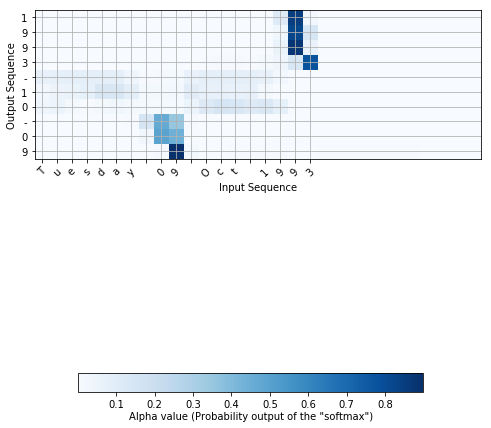

In [37]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)